In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I have seen the movie at the Viennale a few years ago, where the audiences liked it. I liked it as well, Summer Phoenix performance still haunts me, that\xc2\xb4s why I decided to write a comment.<br /><br />The story unfolds in London around 1900, where a jewish girl decides to become an actress. She tries desperately to become one, but it isn\xc2\xb4t before a man treats her badly that she realizes on stage, that she has talent and that she connects with the audience and emerges as a stronger human being.<br /><br />There were certain reviews, were her performance was smashed, they accused her of being dull, not able to bring life to her character. I think that\xc2\xb4s her strong point, that\xc2\xb4s exactly what Esther Kahn should be and Phoenix makes a brave decision to make her Esther a rather boring girl. So her transformation at the end is more powerful than it could have been otherwise. <br /><br />The cinematography is great, the images of London around the turn of

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  26, 108, ...,   0,   0,   0],
       [  2,  64,   5, ...,   0,   0,   0],
       [ 49,  24,   2, ...,   0,   0,   0]], dtype=int64)

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have seen the movie at the Viennale a few years ago, where the audiences liked it. I liked it as well, Summer Phoenix performance still haunts me, that\xc2\xb4s why I decided to write a comment.<br /><br />The story unfolds in London around 1900, where a jewish girl decides to become an actress. She tries desperately to become one, but it isn\xc2\xb4t before a man treats her badly that she realizes on stage, that she has talent and that she connects with the audience and emerges as a stronger human being.<br /><br />There were certain reviews, were her performance was smashed, they accused her of being dull, not able to bring life to her character. I think that\xc2\xb4s her strong point, that\xc2\xb4s exactly what Esther Kahn should be and Phoenix makes a brave decision to make her Esther a rather boring girl. So her transformation at the end is more powerful than it could have been otherwise. <br /><br />The cinematography is great, the images of London around the turn 

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.00446627]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 339ms/step
[0.00446627]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 881s 2s/step - loss: 0.6539 - accuracy: 0.5466 - val_loss: 0.5091 - val_accuracy: 0.7182
Epoch 2/10
391/391 [==============================] - 1186s 3s/step - loss: 0.4372 - accuracy: 0.7895 - val_loss: 0.3964 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 1503s 4s/step - loss: 0.3603 - accuracy: 0.8417 - val_loss: 0.3554 - val_accuracy: 0.8318
Epoch 4/10
391/391 [==============================] - 923s 2s/step - loss: 0.3340 - accuracy: 0.8554 - val_loss: 0.3454 - val_accuracy: 0.8370
Epoch 5/10
391/391 [==============================] - 963s 2s/step - loss: 0.3196 - accuracy: 0.8615 - val_loss: 0.3322 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 745s 2s/step - loss: 0.3096 - accuracy: 0.8658 - val_loss: 0.3245 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 1092s 3s/step - loss: 0.3053 - accuracy: 0.8696 - val_loss: 0.3255 - val_accuracy: 0.8

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 173s 441ms/step - loss: 0.3193 - accuracy: 0.8524
Test Loss: 0.31933480501174927
Test Accuracy: 0.852400004863739


(0.0, 0.6717053726315498)

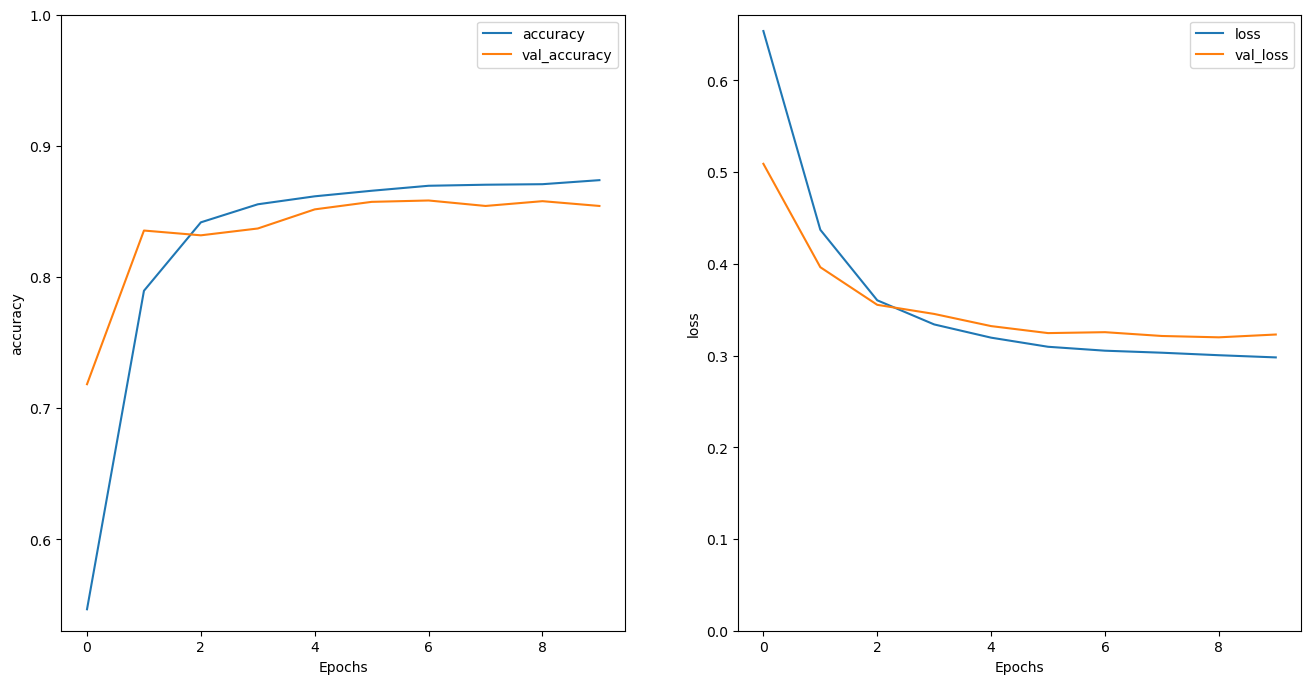

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1546s 4s/step - loss: 0.6142 - accuracy: 0.6040 - val_loss: 0.4270 - val_accuracy: 0.8062
Epoch 2/10
391/391 [==============================] - 1884s 5s/step - loss: 0.3790 - accuracy: 0.8335 - val_loss: 0.3618 - val_accuracy: 0.8531
Epoch 3/10
391/391 [==============================] - 2272s 6s/step - loss: 0.3332 - accuracy: 0.8575 - val_loss: 0.3264 - val_accuracy: 0.8557
Epoch 4/10
148/391 [==========>...................] - ETA: 18:07 - loss: 0.3189 - accuracy: 0.8630

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')